# Experiment Overview: Method Comparison

Compare multiple similarity methods side-by-side:
- **Summary statistics** for each method
- **Performance rankings** across metrics
- **Method correlations** (do methods agree?)
- **Metric distributions** and outlier analysis

For detailed single-method analysis with query visualization, see `method_analysis.ipynb`.

In [15]:
import sys
print(sys.executable)
print(sys.path)

d:\sim-bench\.venv\Scripts\python.exe
['d:\\sim-bench', 'd:\\sim-bench\\sim_bench\\analysis', 'C:\\Program Files\\Python311\\python311.zip', 'C:\\Program Files\\Python311\\DLLs', 'C:\\Program Files\\Python311\\Lib', 'C:\\Program Files\\Python311', 'd:\\sim-bench\\.venv', '', 'd:\\sim-bench\\.venv\\Lib\\site-packages', 'd:\\sim-bench\\.venv\\Lib\\site-packages\\win32', 'd:\\sim-bench\\.venv\\Lib\\site-packages\\win32\\lib', 'd:\\sim-bench\\.venv\\Lib\\site-packages\\Pythonwin']


In [21]:
# Force clean import
import sys

# Add project root
sys.path.insert(0, 'd:\\sim-bench')

# Nuclear option: Clear ALL sim_bench related modules
to_delete = [key for key in sys.modules.keys() if key.startswith('sim_bench')]
for key in to_delete:
    del sys.modules[key]

print(f"Cleared {len(to_delete)} cached modules")
print(f"sys.path[0] = {sys.path[0]}")


Cleared 2 cached modules
sys.path[0] = d:\sim-bench


In [17]:
for c in sys.path:
    print(c)

d:\sim-bench
d:\sim-bench
d:\sim-bench\sim_bench\analysis
C:\Program Files\Python311\python311.zip
C:\Program Files\Python311\DLLs
C:\Program Files\Python311\Lib
C:\Program Files\Python311
d:\sim-bench\.venv

d:\sim-bench\.venv\Lib\site-packages
d:\sim-bench\.venv\Lib\site-packages\win32
d:\sim-bench\.venv\Lib\site-packages\win32\lib
d:\sim-bench\.venv\Lib\site-packages\Pythonwin


In [18]:
!pip show sim_bench

Name: sim-bench
Version: 0.1.0
Summary: Simple, config-driven image similarity benchmarking (UKBench baseline)
Home-page: 
Author: Your Name
Author-email: 
License: MIT
Location: D:\sim-bench\.venv\Lib\site-packages
Editable project location: D:\sim-bench
Requires: matplotlib, numpy, opencv-contrib-python, pandas, Pillow, PyYAML, scikit-learn, scipy, tqdm
Required-by: 


In [19]:
import sys
[a for a in sys.path if 'site_packages' in a]

[]

In [22]:
# %reset
from sim_bench.analysis.utils import get_project_root

In [24]:
# === Imports ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sim_bench.analysis.utils import get_project_root
from sim_bench.analysis.io import load_metrics, load_per_query

sns.set_style('whitegrid')

# === Configuration ===
PROJECT_ROOT = get_project_root()

# Experiment settings
EXPERIMENT_DIR = PROJECT_ROOT / "outputs" / "baseline_runs" / "comprehensive_baseline" / "2025-10-08_16-25-49"
METHODS = ["emd", "deep", "sift_bovw"]  # Methods to compare

# === Validation ===
if not EXPERIMENT_DIR.exists():
    raise FileNotFoundError(f"Experiment directory not found: {EXPERIMENT_DIR}")

# Validate all methods exist
for method in METHODS:
    if not (EXPERIMENT_DIR / method).exists():
        available = [d.name for d in EXPERIMENT_DIR.iterdir() if d.is_dir() and not d.name.startswith('.')]
        raise FileNotFoundError(
            f"Method '{method}' not found in {EXPERIMENT_DIR}\n"
            f"Available: {available}"
        )

print(f"✓ Configuration validated")
print(f"  Experiment: {EXPERIMENT_DIR.relative_to(PROJECT_ROOT)}")
print(f"  Methods: {', '.join(METHODS)}")


✓ Configuration validated
  Experiment: outputs\baseline_runs\comprehensive_baseline\2025-10-08_16-25-49
  Methods: emd, deep, sift_bovw


## 1. Load Data

In [25]:
# Load metrics for all methods
metrics_data = {}
for method in METHODS:
    try:
        df = load_metrics(method, EXPERIMENT_DIR)
        metrics_data[method] = df
        print(f"✓ {method}: {len(df)} metrics")
    except FileNotFoundError:
        print(f"⚠ {method}: metrics.csv not found, skipping")

# Create summary DataFrame
summary_rows = []
for method, df in metrics_data.items():
    row = {'method': method}
    row.update(df.iloc[0].to_dict())
    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows)
print(f"\n✓ Loaded {len(metrics_data)} methods")
df_summary


✓ emd: 1 metrics
✓ deep: 1 metrics
✓ sift_bovw: 1 metrics

✓ Loaded 3 methods


,method,ns,recall@1,recall@4,map@10,num_queries,num_gallery,created_at
0,emd,0.844804,0.401765,0.541373,0.264658,10200,10200,2025-10-09T05:49:39.360181
1,deep,2.828627,0.978922,0.994118,0.946336,10200,10200,2025-10-09T05:58:34.734996
2,sift_bovw,1.522059,0.642647,0.734412,0.500233,10200,10200,2025-10-09T06:12:37.994750


## 2. Performance Summary

In [26]:
# Extract key metrics for comparison
key_metrics = ['map', 'recall@1', 'recall@5', 'recall@10']
available_metrics = [m for m in key_metrics if m in df_summary.columns]

if not available_metrics:
    # Fallback: use all numeric columns except method
    available_metrics = df_summary.select_dtypes(include=[np.number]).columns.tolist()

# Create comparison table
df_comparison = df_summary[['method'] + available_metrics].copy()
df_comparison = df_comparison.set_index('method')

# Highlight best values
print("Performance Comparison (higher is better):")
df_comparison.style.highlight_max(axis=0, color='lightgreen')


Performance Comparison (higher is better):


,recall@1
method,
emd,0.401765
deep,0.978922
sift_bovw,0.642647


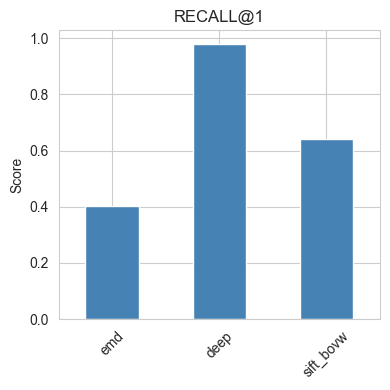

In [27]:
# Visualize performance across methods
if len(available_metrics) > 0:
    fig, axes = plt.subplots(1, min(4, len(available_metrics)), figsize=(4 * min(4, len(available_metrics)), 4))
    if len(available_metrics) == 1:
        axes = [axes]
    
    for idx, metric in enumerate(available_metrics[:4]):
        ax = axes[idx]
        df_comparison[metric].plot(kind='bar', ax=ax, color='steelblue')
        ax.set_title(f'{metric.upper()}')
        ax.set_ylabel('Score')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠ No metrics available for visualization")


C:\Users\Jonathan Hexner\AppData\Local\Temp\ipykernel_25468\348298130.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=methods, patch_artist=True)


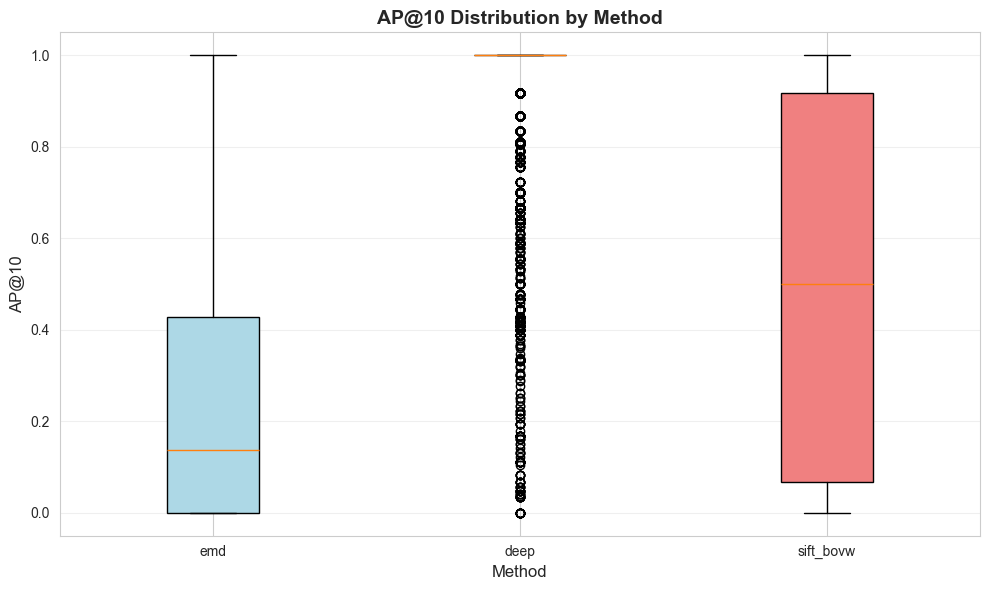


AP@10 Statistics:
emd             | Mean: 0.2647 | Median: 0.1361 | Std: 0.3074
deep            | Mean: 0.9463 | Median: 1.0000 | Std: 0.1519
sift_bovw       | Mean: 0.5002 | Median: 0.5000 | Std: 0.3881


{'emd': array([0.333333, 0.055556, 0.416667, ..., 0.333333, 0.666667, 0.055556]),
 'deep': array([1.      , 0.916667, 1.      , ..., 0.833333, 1.      , 1.      ]),
 'sift_bovw': array([1. , 1. , 1. , ..., 0.3, 0. , 0.7])}

In [31]:
def plot_metric_comparison(methods, experiment_dir, metric='ap@10', figsize=(10, 6)):
    """
    Compare a metric across methods using box plots.
    
    Args:
        methods: List of method names
        experiment_dir: Path to experiment directory
        metric: Metric column name to compare
        figsize: Figure size
    """
    # Load per-query data for all methods
    data = {}
    for method in methods:
        df = load_per_query(method, experiment_dir)
        data[method] = df[metric].values
    
    # Create box plot
    fig, ax = plt.subplots(figsize=figsize)
    
    data_to_plot = [data[method] for method in methods]
    bp = ax.boxplot(data_to_plot, labels=methods, patch_artist=True)
    
    # Color boxes
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors[:len(methods)]):
        patch.set_facecolor(color)
    
    ax.set_ylabel(metric.upper(), fontsize=12)
    ax.set_xlabel('Method', fontsize=12)
    ax.set_title(f'{metric.upper()} Distribution by Method', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{metric.upper()} Statistics:")
    for method in methods:
        values = data[method]
        print(f"{method:15s} | Mean: {values.mean():.4f} | Median: {np.median(values):.4f} | Std: {values.std():.4f}")
    
    return data


# Use it
plot_metric_comparison(METHODS, EXPERIMENT_DIR, metric='ap@10')

## 3. Method Rankings

In [28]:
# Rank methods by each metric
df_ranks = df_comparison.rank(ascending=False, method='min').astype(int)
df_ranks.columns = [f'{col}_rank' for col in df_ranks.columns]

# Add average rank
df_ranks['avg_rank'] = df_ranks.mean(axis=1)
df_ranks = df_ranks.sort_values('avg_rank')

print("Method Rankings (1=best):")
df_ranks


Method Rankings (1=best):


,recall@1_rank,avg_rank
method,,
deep,1,1.0
sift_bovw,2,2.0
emd,3,3.0


## 4. Method Correlation Analysis

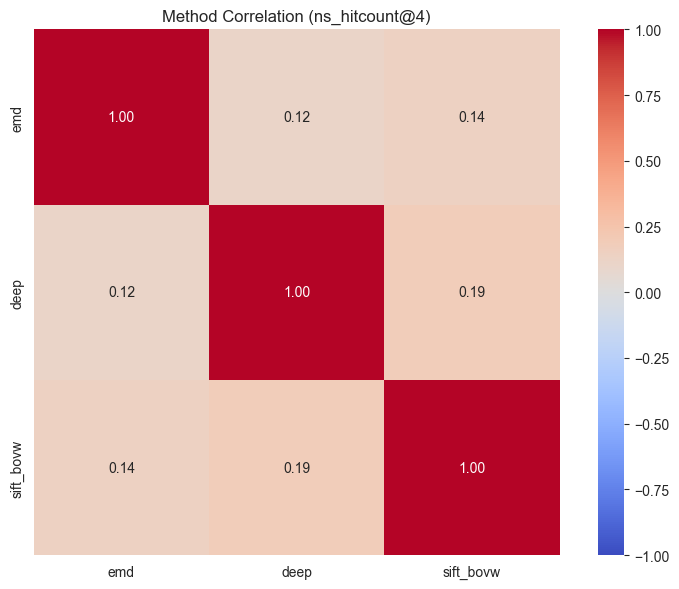


Correlation analysis based on: ns_hitcount@4
High correlation = methods agree on query difficulty


In [29]:
# Load per-query results to analyze correlations
per_query_data = {}
for method in METHODS:
    try:
        df = load_per_query(method, EXPERIMENT_DIR)
        per_query_data[method] = df
    except FileNotFoundError:
        print(f"⚠ {method}: per_query.csv not found")

if len(per_query_data) >= 2:
    # Choose a metric to compare (e.g., first available numeric column)
    sample_df = next(iter(per_query_data.values()))
    metric_cols = sample_df.select_dtypes(include=[np.number]).columns.tolist()
    metric_cols = [c for c in metric_cols if c not in ['query_idx', 'group_id']]
    
    if metric_cols:
        compare_metric = metric_cols[0]  # Use first available metric
        
        # Create comparison DataFrame
        df_compare = pd.DataFrame()
        for method, df in per_query_data.items():
            if compare_metric in df.columns:
                df_compare[method] = df[compare_metric].values
        
        # Compute correlation
        corr_matrix = df_compare.corr()
        
        # Visualize
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                   vmin=-1, vmax=1, square=True)
        plt.title(f'Method Correlation ({compare_metric})')
        plt.tight_layout()
        plt.show()
        
        print(f"\nCorrelation analysis based on: {compare_metric}")
        print("High correlation = methods agree on query difficulty")
    else:
        print("⚠ No numeric metrics available for correlation analysis")
else:
    print("⚠ Need at least 2 methods for correlation analysis")


## 5. Summary

In [30]:
print("=" * 60)
print("EXPERIMENT SUMMARY")
print("=" * 60)
print(f"Experiment: {EXPERIMENT_DIR.name}")
print(f"Methods compared: {len(METHODS)}")
print(f"\nBest method by average rank: {df_ranks.index[0]}")
print(f"\nFor detailed analysis of a specific method, see method_analysis.ipynb")


EXPERIMENT SUMMARY
Experiment: 2025-10-08_16-25-49
Methods compared: 3

Best method by average rank: deep

For detailed analysis of a specific method, see method_analysis.ipynb
